In [1]:
from delta_bulk import *

2024-09-20 00:47:49.738710: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
from einops import rearrange, reduce, repeat, einsum

# Training run

In [3]:

cuts = [64 * 12, 64 * 24, 64 * 28]
X_train, X_val, X_test = X[:cuts[0]], X[cuts[0]:cuts[1]], X[cuts[1]:cuts[2]]
Y_train, Y_val, Y_test = Y[:cuts[0]], Y[cuts[0]:cuts[1]], Y[cuts[1]:cuts[2]]

In [4]:

cfg = TrainConfig(num_epochs=25, optimizer="sgd", lr=0.1, scheduler="cosine")

key = jax.random.key(seed)
ref_key, key = jax.random.split(key)

ref_params = model.init(ref_key, X)
raveled_ref_params, unravel = ravel_pytree(ref_params)

@partial(jax.pmap, in_axes=(0))
def train_pmap(raveled_params):
    J, (metrics, state) = jac_fn(raveled_params, X_train, Y_train, model.apply, cfg, unravel)
    final_params, (metrics, state) = train(raveled_params, X_train, Y_train, model.apply, cfg, unravel)
    return final_params, J, metrics, state

In [6]:
iters = 1
return_J = True

keys = jax.random.split(key, 8 * iters)

# delta_bulks = []
deltas = []
Js = []

for i in trange(iters):
    init_params = []
    for j in range(8):
        init_param = model.init(keys[i * 8 + j], X)
        # if aligned:
        #     init_param, _, _ = alignment.align_networks(
        #         init_param, 
        #         ref_params, 
        #         symmetric=symmetric,
        #         canonicalize=canonicalize,
        #     )
        init_param = ravel_pytree(init_param)[0]
        init_params.append(init_param)

    init_params = jnp.stack(init_params)

    final_params, J, metrics, state = train_pmap(init_params)

    for i in range(8):
        # u, s, vt = u8[i], s8[i], vt8[i]
        final_params_i = final_params[i]
        init_params_i = init_params[i]
        delta = final_params_i - init_params_i
        deltas.append(delta)
        
        # dists = jnp.abs(s - 1)
        # bulk = jnp.argsort(dists)[:2000]
        # proj = vt[bulk, :]
        # delta_bulk = proj.T @ (proj @ delta)
        # delta_bulks.append(delta_bulk)
        if return_J:
            Js.append(J[i])

100%|██████████| 1/1 [00:13<00:00, 13.92s/it]


In [49]:
metrics[0][0]

Array([2.0186052 , 0.81120294, 0.3259407 , 0.24711692, 0.20192486,
       0.20213032, 0.18003875, 0.13452876, 0.10572217, 0.09283712,
       0.07104117, 0.06500044, 0.06146143, 0.05764049, 0.05514237,
       0.05307601, 0.05147342, 0.05019249, 0.0492174 , 0.04846703,
       0.04793356, 0.04756957, 0.04734202, 0.04722046, 0.0471736 ],      dtype=float32)

In [88]:
metrics[1][7]

Array([0.06119792, 0.3138021 , 0.5911459 , 0.75      , 0.8059896 ,
       0.83463544, 0.8541667 , 0.875     , 0.8828125 , 0.890625  ,
       0.8958334 , 0.9036459 , 0.9114584 , 0.9153646 , 0.9231771 ,
       0.9244792 , 0.9296875 , 0.93359375, 0.93359375, 0.93359375,
       0.9375    , 0.9453125 , 0.9466146 , 0.95182294, 0.95182294],      dtype=float32)

In [3]:
deltas, delta_bulks, Js = expt(save_dir=None, return_J=True)

100%|██████████| 1/1 [03:07<00:00, 187.06s/it]


(9610,) (9610, 9610)
0.023878574
[0.06343067 0.0648779  0.06981567 0.06656377 0.06666046 0.06691065
 0.0718051  0.07077493]
ratio: 8.028794


In [10]:
Js =jnp.stack(Js)

In [11]:
Js.shape

(8, 9610, 9610)

In [12]:
u8, s8, vt8 = jax.pmap(jnp.linalg.svd)(Js)

# Plots and expts

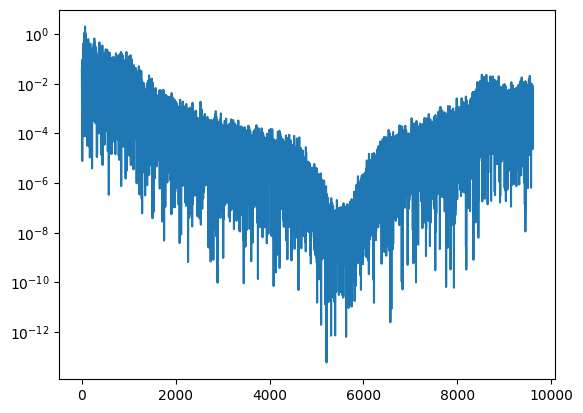

In [7]:
s = s8[0]
vt = vt8[0]

flattest = jnp.argsort(s)
projected = vt[flattest] @ deltas[0]

plt.plot((projected)**2)
plt.yscale("log")
plt.show()

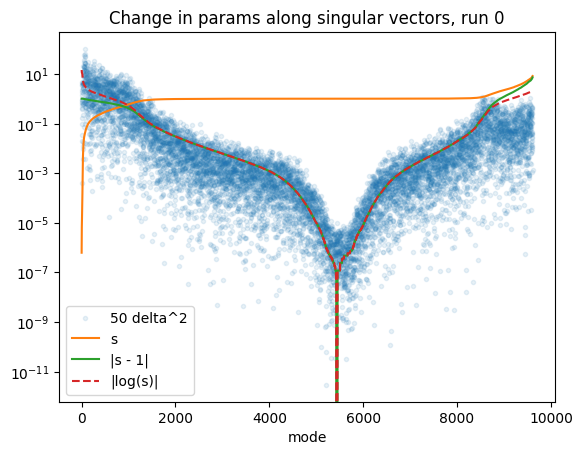

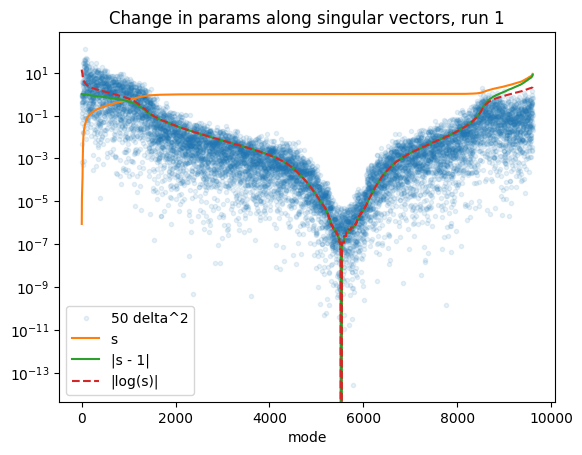

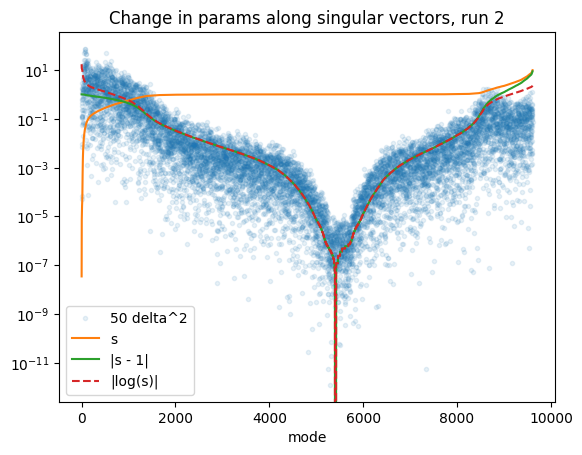

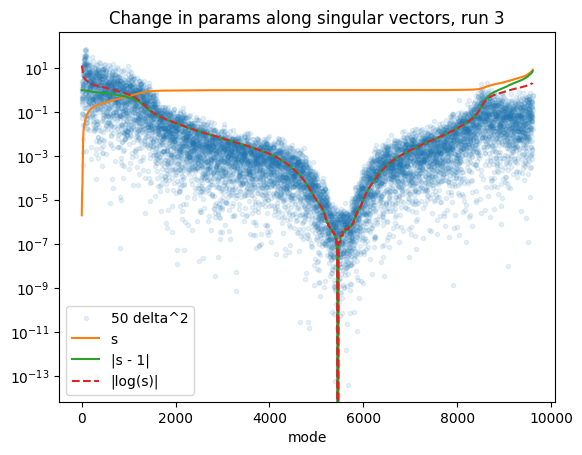

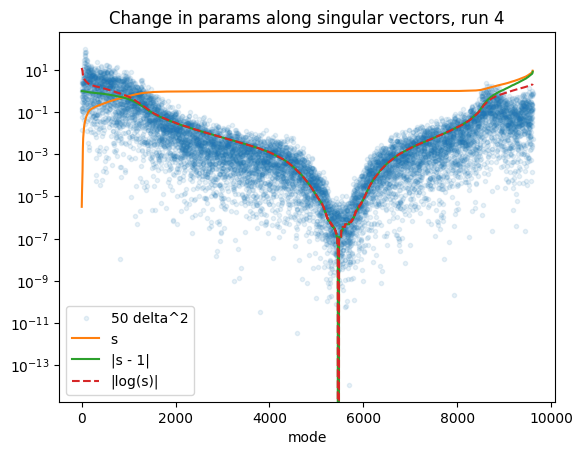

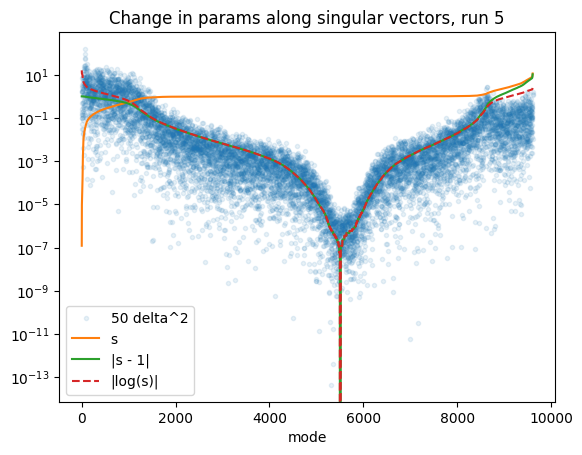

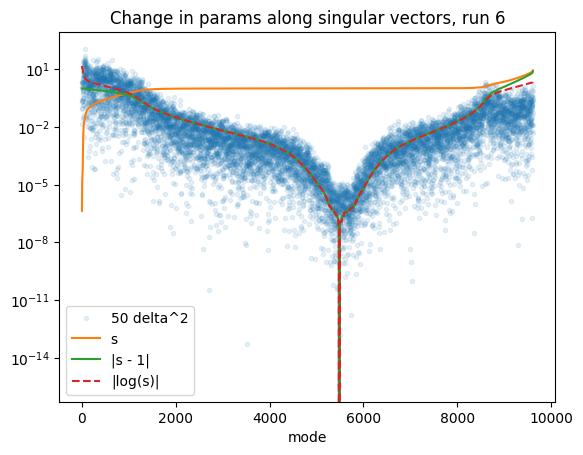

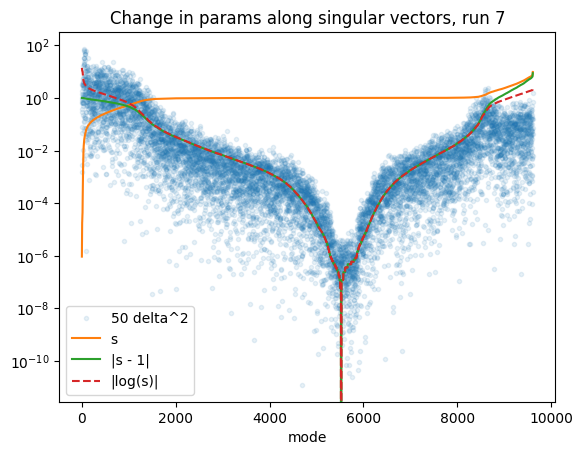

In [35]:
for i in range(8):
    s = s8[i]
    vt = vt8[i]

    flattest = jnp.argsort(s)
    projected = vt[flattest] @ deltas[i]

    plt.plot(50 * (projected)**2, '.', alpha=0.1, label="50 delta^2")
    plt.plot(s[flattest], label="s")
    plt.plot(jnp.abs(s[flattest] - 1), label="|s - 1|")
    plt.plot(jnp.abs(jnp.log(s[flattest])), '--', label="|log(s)|")
    plt.yscale("log")
    plt.xlabel("mode")
    plt.legend()
    plt.title(f"Change in params along singular vectors, run {i}")
    plt.show()

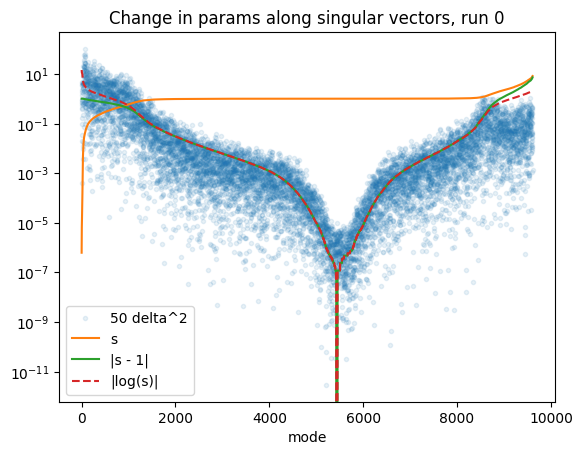

In [12]:
for i in range(1):
    s = s8[i]
    vt = vt8[i]

    flattest = jnp.argsort(s)
    projected = vt[flattest] @ deltas[i]

    plt.plot(50 * (projected)**2, '.', alpha=0.1, label="50 delta^2")
    plt.plot(s[flattest], label="s")
    plt.plot(jnp.abs(s[flattest] - 1), label="|s - 1|")
    plt.plot(jnp.abs(jnp.log(s[flattest])), '--', label="|log(s)|")
    plt.yscale("log")
    plt.xlabel("mode")
    plt.legend()
    plt.title(f"Change in params along singular vectors, run {i}")
    plt.show()

## poisoned

In [18]:
with open("/mnt/ssd-1/nora/sgdensity/poisoned_init.npy", "rb") as f:
    poisoned_init = jnp.load(f)
poisoned_init.shape

(9610,)

In [19]:
import meta_poisoning as mp

/home/adam/.conda/envs/jax_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [134]:
from importlib import reload
reload(mp)

<module 'meta_poisoning' from '/home/adam/src/sgdensity/meta_poisoning.py'>

In [20]:
def mp_train(params0, return_params=False, num_epochs=25):
    X, Y = mp.load_digits(return_X_y=True)
    X = X / 16.0  # Normalize

    # Split data
    X_train, X_test, Y_train, Y_test = mp.train_test_split(
        X, Y, test_size=197, random_state=0
    )

    seed = 0
    d_inner = X.shape[1] * 2

    model = mp.MLP(hidden_sizes=(d_inner,), out_features=10)

    params_ = model.init(jax.random.key(seed), X_train)
    params0_, unravel = ravel_pytree(params_)

    cfg = mp.TrainConfig(num_epochs=num_epochs)

    return mp.train(
        params0, 
        X_train, Y_train, 
        X_test, Y_test, 
        mp.make_apply_full(model, unravel),
        cfg,
        return_params=return_params
    )

In [21]:
test_loss, train_loss = mp_train(poisoned_init)
test_loss, train_loss

(Array(2.0537686, dtype=float32), Array(0.02641672, dtype=float32))

In [38]:
params1 = mp_train(poisoned_init, return_params=True)
params1.shape

(9610,)

In [23]:
test_loss, train_loss = mp_train(poisoned_init, return_params=False, num_epochs=100)
test_loss, train_loss

(Array(2.0994313, dtype=float32), Array(0.00298554, dtype=float32))

In [188]:
test_loss, train_loss = mp_train(poisoned_init, return_params=False, num_epochs=100)
test_loss, train_loss

(Array(2.0994313, dtype=float32), Array(0.00298554, dtype=float32))

In [24]:
jac = jax.jacfwd(lambda x: mp_train(x, return_params=True))
J_mp = jac(poisoned_init)

In [25]:
J_mp.shape

(9610, 9610)

In [26]:
u_mp, s_mp, vt_mp = jnp.linalg.svd(J_mp)

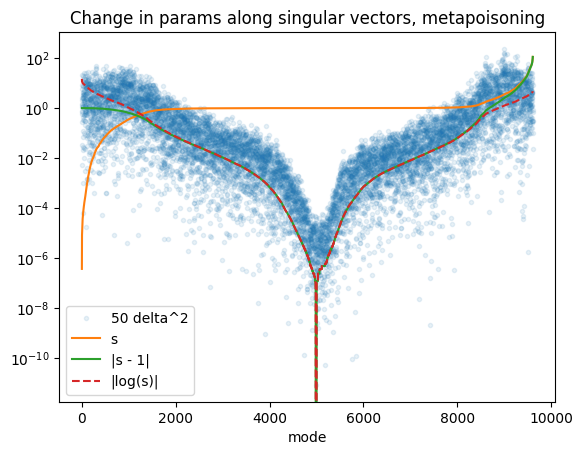

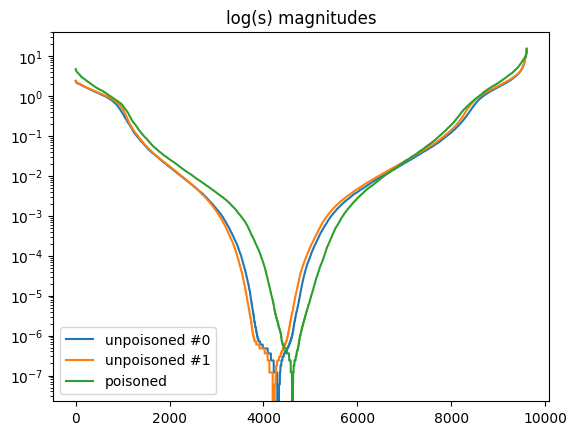

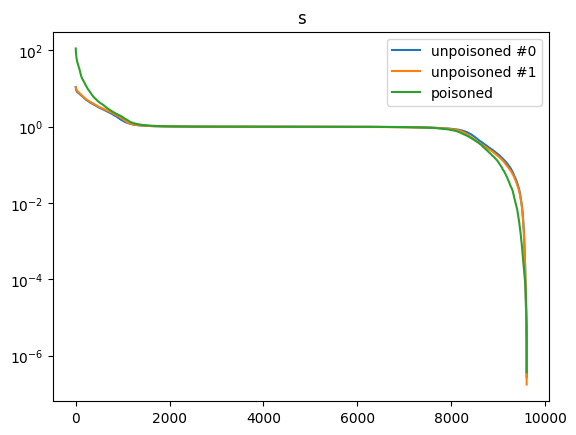

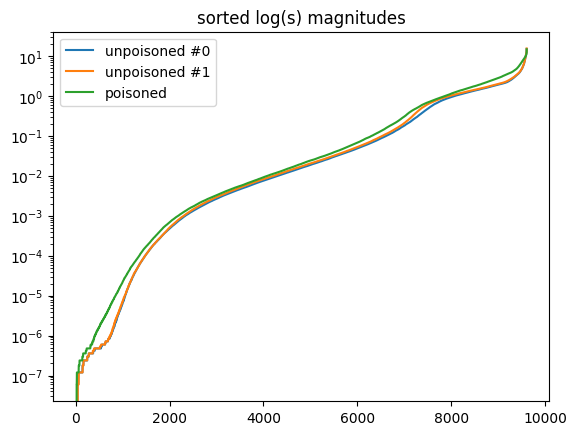

In [30]:

s = s_mp
vt = vt_mp

flattest = jnp.argsort(s)
delta = params1 - poisoned_init
projected = vt[flattest] @ delta

plt.plot(50 * (projected)**2, '.', alpha=0.1, label="50 delta^2")
plt.plot(s[flattest], label="s")
plt.plot(jnp.abs(s[flattest] - 1), label="|s - 1|")
plt.plot(jnp.abs(jnp.log(s[flattest])), '--', label="|log(s)|")
plt.yscale("log")
plt.xlabel("mode")
plt.legend()
plt.title(f"Change in params along singular vectors, metapoisoning")
plt.show()

plt.plot(jnp.abs(jnp.log(s8[0])), label="unpoisoned #0")
plt.plot(jnp.abs(jnp.log(s8[1])), label="unpoisoned #1")
plt.plot(jnp.abs(jnp.log(s_mp)), label="poisoned")
plt.yscale("log")
plt.legend()
plt.title("log(s) magnitudes")
plt.show()
plt.plot((s8[0]), label="unpoisoned #0")
plt.plot((s8[1]), label="unpoisoned #1")
plt.plot(s_mp, label="poisoned")
plt.yscale("log")
plt.legend()
plt.title("s")
plt.show()

plt.plot(jnp.sort(jnp.abs(jnp.log(s8[0]))), label="unpoisoned #0")
plt.plot(jnp.sort(jnp.abs(jnp.log(s8[1]))), label="unpoisoned #1")
plt.plot(jnp.sort(jnp.abs(jnp.log(s_mp))), label="poisoned")
plt.yscale("log")
plt.legend()
plt.title("sorted log(s) magnitudes")
plt.show()

In [31]:
def foo():
    X, Y = load_digits(return_X_y=True)
    X = X / 16.0  # Normalize

    # Split data
    X_train, X_test, Y_train, Y_test = mp.train_test_split(
        X, Y, test_size=197, random_state=0
    )


    seed = 0
    d_inner = X.shape[1] * 2
    mp_model = mp.MLP(hidden_sizes=(d_inner,), out_features=10)
    params_ = mp_model.init(jax.random.key(seed), X_train)
    params_, unravel = ravel_pytree(params_)
    print(mp.compute_loss(dict(p=unravel(params1)), mp_model.apply, X_test, Y_test))
    print(mp.compute_loss(dict(p=unravel(params1)), mp_model.apply, X_train, Y_train))
    print(mp.compute_loss(dict(p=unravel(poisoned_init)), mp_model.apply, X_test, Y_test))
    print(mp.compute_loss(dict(p=unravel(poisoned_init)), mp_model.apply, X_train, Y_train))
    print(mp.compute_loss(dict(p=unravel(params_)), mp_model.apply, X_test, Y_test))
    print(mp.compute_loss(dict(p=unravel(params_)), mp_model.apply, X_train, Y_train))

    return mp_model, X_train, Y_train, X_test, Y_test
mp_model, mp_X_train, mp_Y_train, mp_X_test, mp_Y_test = foo()

(Array(2.0537686, dtype=float32), Array(0.8629441, dtype=float32))
(Array(0.02640858, dtype=float32), Array(0.99875, dtype=float32))
(Array(10.474096, dtype=float32), Array(0.11167513, dtype=float32))
(Array(9.641706, dtype=float32), Array(0.096875, dtype=float32))
(Array(2.3185372, dtype=float32), Array(0.03045685, dtype=float32))
(Array(2.2937737, dtype=float32), Array(0.061875, dtype=float32))


In [161]:
[*unravel(poisoned_init)['params']['Dense_0'].keys()]

['bias', 'kernel']

In [164]:
def walk_dict_tree(d):
    for k, v in d.items():
        if isinstance(v, dict):
            print(k)
            walk_dict_tree(v)
            print('\\',k)
        else:
            print(k, v.shape)
walk_dict_tree(unravel(poisoned_init))

params
Dense_0
bias (128,)
kernel (64, 128)
\ Dense_0
Dense_1
bias (10,)
kernel (128, 10)
\ Dense_1
\ params


In [182]:
for p in [poisoned_init, params1, final_params[0]]:
    for k, v in unravel(p)['params'].items():
        for k2, v2 in v.items():
            print(k, k2, v2.shape, '\t\t', jnp.linalg.norm(v2))
# print(jnp.linalg.norm(unravel(poisoned_init)['params']['Dense_0']['bias']))
# print(jnp.linalg.norm(unravel(poisoned_init)['params']['Dense_1']['bias']))
# print(jnp.linalg.norm(unravel(params1)['params']['Dense_0']['bias']))
# print(jnp.linalg.norm(unravel(params1)['params']['Dense_1']['bias']))



Dense_0 bias (128,) 		 1.6092159
Dense_0 kernel (64, 128) 		 10.567034
Dense_1 bias (10,) 		 1.38813
Dense_1 kernel (128, 10) 		 4.735956
Dense_0 bias (128,) 		 1.4088981
Dense_0 kernel (64, 128) 		 15.187495
Dense_1 bias (10,) 		 1.5031073
Dense_1 kernel (128, 10) 		 15.242499
Dense_0 bias (128,) 		 0.6405998
Dense_0 kernel (64, 128) 		 12.663412
Dense_1 bias (10,) 		 0.095820956
Dense_1 kernel (128, 10) 		 6.21152


In [179]:
# params_ = mp_model.init(jax.random.key(0), X_train)
print(jnp.linalg.norm(unravel(final_params[2])['params']['Dense_0']['bias']))
print(jnp.linalg.norm(unravel(final_params[2])['params']['Dense_1']['bias']))

0.6538002
0.1626758


In [125]:
type(poisoned_init)

jaxlib.xla_extension.ArrayImpl

In [1]:
final_params.shape

NameError: name 'final_params' is not defined

## Basin radius

In [60]:
ravel_pytree(rand_init)

(Array([ 0.        ,  0.        ,  0.        , ..., -0.01018905,
         0.09268761, -0.14688015], dtype=float32),
 <jax._src.util.HashablePartial at 0x759c1420a490>)

96.66748 11.773188
random 0.40488544 0.0022143063
random init 0.15114431 0.026499106


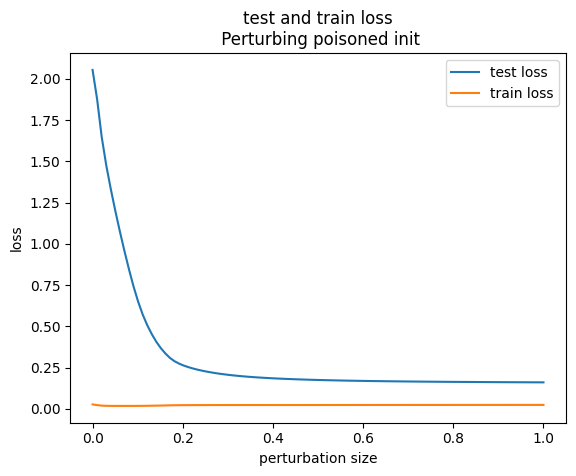

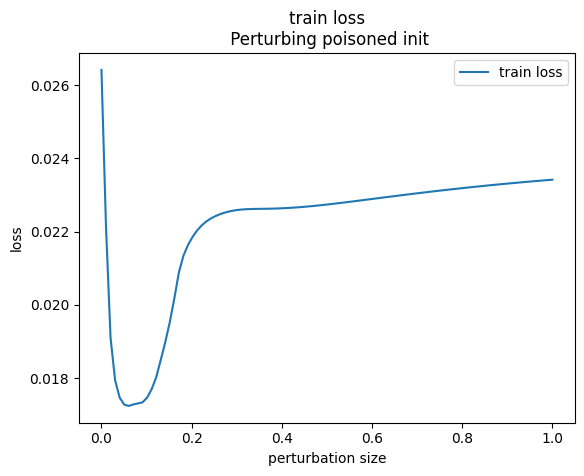

In [65]:
rand_dir = jax.random.normal(jax.random.key(1), poisoned_init.shape)
print(jnp.linalg.norm(rand_dir), jnp.linalg.norm(poisoned_init))
test_loss, train_loss = mp_train(rand_dir, return_params=False)
print("random", test_loss, train_loss)
rand_init = ravel_pytree(mp_model.init(jax.random.key(1), mp_X_train))[0]
test_loss, train_loss = mp_train(rand_init, return_params=False)
print("random init", test_loss, train_loss)

test_losses = []
train_losses = []
for t in jnp.linspace(0, 1, 100):
    pert_init = poisoned_init + t * rand_dir
    pert_init *= jnp.linalg.norm(poisoned_init) / jnp.linalg.norm(pert_init)
    test_loss, train_loss = mp_train(pert_init, return_params=False)
    test_losses.append(test_loss)
    train_losses.append(train_loss)

In [72]:
jnp.sqrt(jnp.mean(poisoned_init**2))

Array(0.12009706, dtype=float32)

In [82]:
kernel0 = unravel(rand_init)['params']['Dense_0']['kernel']
kernel1 = unravel(rand_init)['params']['Dense_1']['kernel']
jnp.std(kernel0), jnp.std(kernel1)

(Array(0.12484559, dtype=float32), Array(0.09040622, dtype=float32))

In [83]:
.125 * jnp.sqrt(2)/2

Array(0.08838835, dtype=float32, weak_type=True)

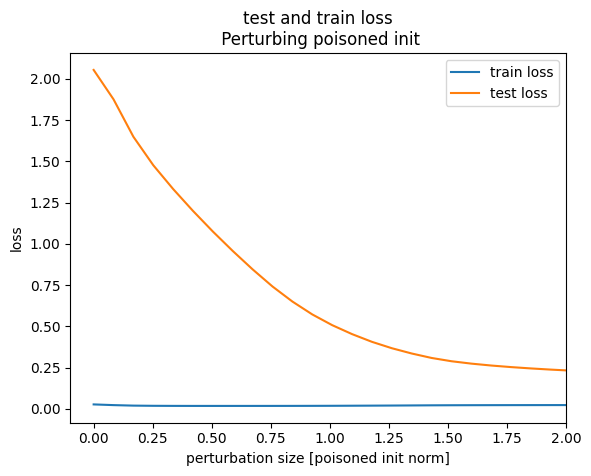

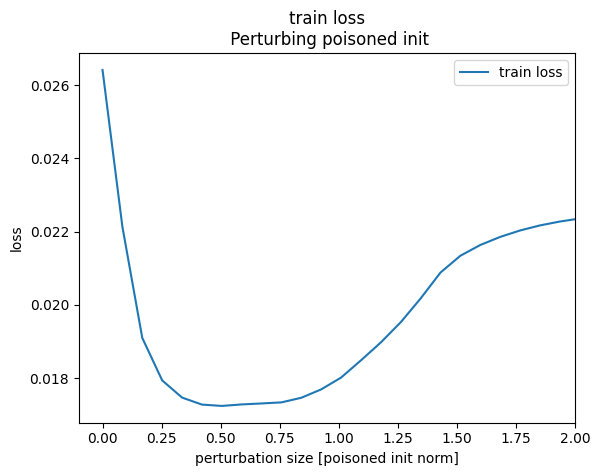

In [77]:

plt.plot(jnp.linspace(0, 1/.12, 100), train_losses, label="train loss")
plt.plot(jnp.linspace(0, 1/.12, 100), test_losses, label="test loss")
plt.xlabel("perturbation size [poisoned init norm]")
plt.ylabel("loss")
plt.xlim(-.1, 2)
plt.legend()
plt.title("test and train loss\n Perturbing poisoned init")
plt.show()
#plt.plot(jnp.linspace(0, 1, 100), test_losses, label="test loss")
plt.plot(jnp.linspace(0, 1/.12, 100),  train_losses, label="train loss")
plt.xlabel("perturbation size [poisoned init norm]")
plt.ylabel("loss")
plt.xlim(-.1, 2)
plt.legend()
plt.title("train loss\n Perturbing poisoned init")
plt.show()

## Splice [poisoned]

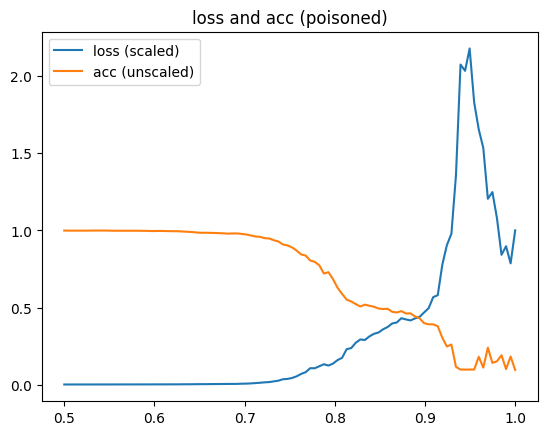

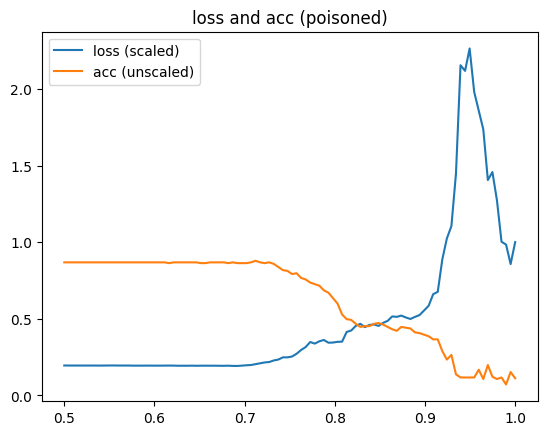

In [39]:
i = 0

s = s_mp
vt = vt_mp

init_params_i = poisoned_init
final_params_i = params1
delta_i = final_params_i - init_params_i

dim = s.shape[0]

flattest = jnp.argsort(jnp.abs(s - 1))
dimfracs = jnp.linspace(0.5, 1, 100)


for myX, myY in [(mp_X_train, mp_Y_train), (mp_X_test, mp_Y_test)]:

    spliced_losses = []
    spliced_accs = []

    for dimfrac in dimfracs:
        bulkdim = int(dim * dimfrac)

        proj = vt[flattest][:bulkdim]
        projected = proj.T @ (proj @ delta_i)

        spliced = final_params_i - projected

        loss, acc = loss_fn(unravel(spliced), mp_model.apply, myX, myY)
        spliced_losses.append(loss)
        spliced_accs.append(acc)

        #spliced = repeat(final_params_i, 'd -> b d', b=100) - einsum(projected, t, 'd, b -> b d')

    init_loss, init_acc = loss_fn(unravel(init_params_i), mp_model.apply, myX, myY)
    final_loss, final_acc = loss_fn(unravel(final_params_i), mp_model.apply, myX, myY)

    spliced_losses = jnp.stack(spliced_losses)
    spliced_accs = jnp.stack(spliced_accs)

    spliced_losses_scaled = (spliced_losses - init_loss) / (final_loss - init_loss)
    spliced_accs_scaled = (spliced_accs - init_acc) / (final_acc - init_acc)

    plt.plot(dimfracs, spliced_losses / init_loss, label="loss (scaled)")
    plt.plot(dimfracs, spliced_accs, label="acc (unscaled)")
    plt.legend()
    plt.title('loss and acc (poisoned)')
    plt.show()

    spliced_losses_p = spliced_losses
    spliced_accs_p = spliced_accs

In [264]:
losses = []
accs = []
for param in spliced:
    loss, acc = loss_fn(unravel(param), model.apply, X_test, Y_test)
    losses.append(loss)
    accs.append(acc)
losses = jnp.stack(losses)
accs = jnp.stack(accs)
losses.shape, accs.shape

((100,), (100,))

In [265]:
init_loss, init_acc = loss_fn(unravel(init_params_i), model.apply, X_test, Y_test)
final_loss, final_acc = loss_fn(unravel(final_params_i), model.apply, X_test, Y_test)


In [273]:
final_loss

Array(0.46607655, dtype=float32)

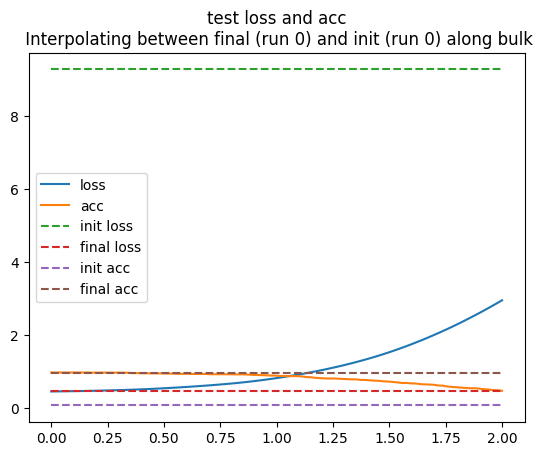

In [266]:
plt.plot(t, losses, label="loss")
plt.plot(t, accs, label="acc")
# init and final loss as horizontal lines
plt.plot(t, jnp.ones_like(t) * init_loss, '--', label="init loss")
plt.plot(t, jnp.ones_like(t) * final_loss, '--', label="final loss")
plt.plot(t, jnp.ones_like(t) * init_acc, '--', label="init acc")
plt.plot(t, jnp.ones_like(t) * final_acc, '--', label="final acc")
plt.legend()
plt.title("test loss and acc\n Interpolating between final (run 0) and init (run 0) along bulk")
plt.show()

## Splice [unpoisoned, scan]

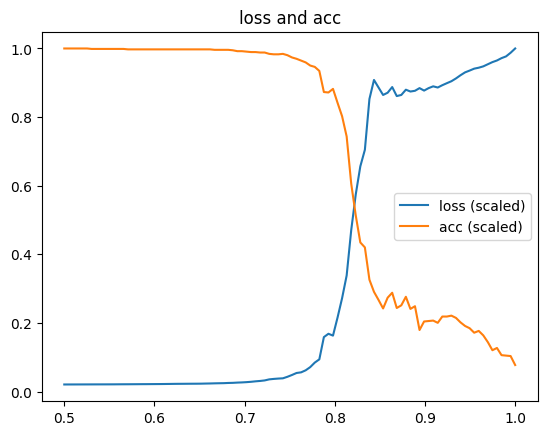

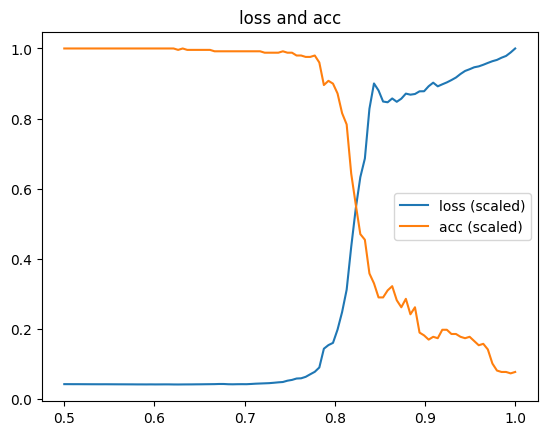

In [40]:
i = 0

s = s8[i]
vt = vt8[i]

init_params_i = init_params[i]
final_params_i = final_params[i]
delta_i = final_params_i - init_params_i

my_model = model

dim = s.shape[0]

flattest = jnp.argsort(jnp.abs(s - 1))
dimfracs = jnp.linspace(0.5, 1, 100)


for myX, myY in [(X_train, Y_train), (X_test, Y_test)]:

    spliced_losses = []
    spliced_accs = []

    for dimfrac in dimfracs:
        bulkdim = int(dim * dimfrac)

        proj = vt[flattest][:bulkdim]
        projected = proj.T @ (proj @ delta_i)

        spliced = final_params_i - projected

        loss, acc = loss_fn(unravel(spliced), my_model.apply, myX, myY)
        spliced_losses.append(loss)
        spliced_accs.append(acc)

        #spliced = repeat(final_params_i, 'd -> b d', b=100) - einsum(projected, t, 'd, b -> b d')

    init_loss, init_acc = loss_fn(unravel(init_params_i), my_model.apply, myX, myY)
    final_loss, final_acc = loss_fn(unravel(final_params_i), my_model.apply, myX, myY)

    spliced_losses = jnp.stack(spliced_losses)
    spliced_accs = jnp.stack(spliced_accs)

    spliced_losses_scaled = (spliced_losses - init_loss) / (final_loss - init_loss)
    spliced_accs_scaled = (spliced_accs - init_acc) / (final_acc - init_acc)

    plt.plot(dimfracs, spliced_losses / init_loss, label="loss (scaled)")
    plt.plot(dimfracs, spliced_accs / final_acc, label="acc (scaled)")
    plt.legend()
    plt.title('loss and acc')
    plt.show()

### both

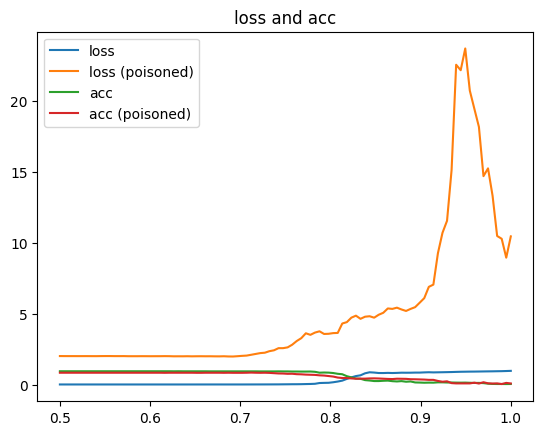

In [41]:

plt.plot(dimfracs, spliced_losses / init_loss, label="loss")
plt.plot(dimfracs, spliced_losses_p, label="loss (poisoned)")
plt.plot(dimfracs, spliced_accs, label="acc")
plt.plot(dimfracs, spliced_accs_p, label="acc (poisoned)")
plt.legend()
plt.title('loss and acc')
plt.show()

## Splice [original]

In [267]:
i = 0

s = s8[i]
vt = vt8[i]

init_params_i = init_params[i]
final_params_i = final_params[i]
delta_i = final_params_i - init_params_i
delta_ij = final_params_i - init_params[1]

dim = s.shape[0]
bulkdim = int(dim * .75)

flattest = jnp.argsort(jnp.abs(s - 1))
proj = vt[flattest][:bulkdim]
projected = proj.T @ (proj @ delta_i)

t = jnp.linspace(0, 2, 100)
spliced = repeat(final_params_i, 'd -> b d', b=100) - einsum(projected, t, 'd, b -> b d')



In [268]:
losses = []
accs = []
for param in spliced:
    loss, acc = loss_fn(unravel(param), model.apply, X_test, Y_test)
    losses.append(loss)
    accs.append(acc)
losses = jnp.stack(losses)
accs = jnp.stack(accs)
losses.shape, accs.shape

((100,), (100,))

In [269]:
init_loss, init_acc = loss_fn(unravel(init_params_i), model.apply, X_test, Y_test)
final_loss, final_acc = loss_fn(unravel(final_params_i), model.apply, X_test, Y_test)


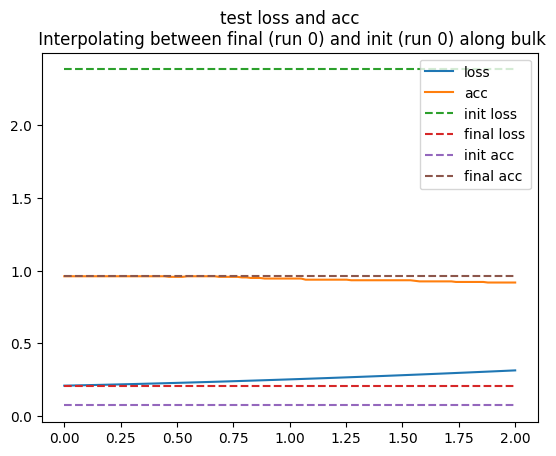

In [270]:
plt.plot(t, losses, label="loss")
plt.plot(t, accs, label="acc")
# init and final loss as horizontal lines
plt.plot(t, jnp.ones_like(t) * init_loss, '--', label="init loss")
plt.plot(t, jnp.ones_like(t) * final_loss, '--', label="final loss")
plt.plot(t, jnp.ones_like(t) * init_acc, '--', label="init acc")
plt.plot(t, jnp.ones_like(t) * final_acc, '--', label="final acc")
plt.legend()
plt.title("test loss and acc\n Interpolating between final (run 0) and init (run 0) along bulk")
plt.show()

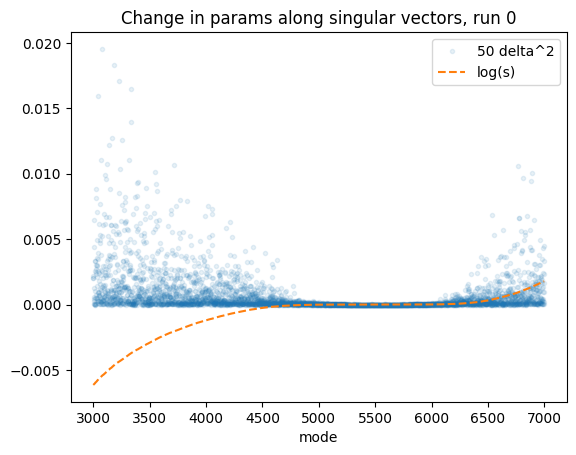

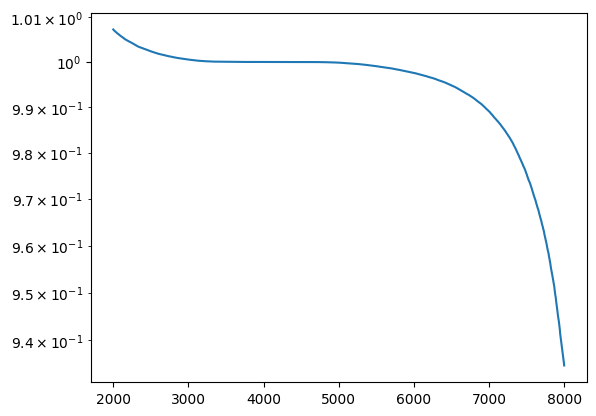

In [51]:
i = 0
s = s8[i]
vt = vt8[i]

flattest = jnp.argsort(s)
projected = vt[flattest] @ deltas[i]


plt.plot(jnp.arange(3000, 7000), 50 * (projected[3000:7000])**2, '.', alpha=0.1, label="50 delta^2")
plt.plot(jnp.arange(3000, 7000), jnp.log(s[flattest])[3000:7000], '--', label="log(s)")
plt.xlabel("mode")
plt.legend()
plt.title(f"Change in params along singular vectors, run {i}")
plt.show()

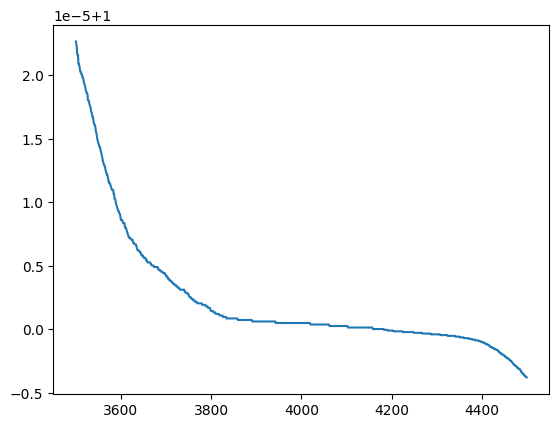

In [56]:

plt.plot(jnp.arange(3500, 4500), s[3500:4500])
#plt.yscale("log")
plt.show()